# Step-by-step DA for the basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

## Data Assimilation

In [6]:
L = 10

In [7]:
lvl_grid_args = initGridSpecs(L)
args = {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } 

In [8]:
from utils.BasinParameters import *

In [9]:
data_args = make_init_steady_state(args, a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) 

### Truth

In [10]:
from gpuocean.SWEsimulators import ModelErrorKL
true_init_mekl = ModelErrorKL.ModelErrorKL(**args, **init_model_error_basis_args)
true_sim_mekl = ModelErrorKL.ModelErrorKL(**args, **sim_model_error_basis_args)

truth = make_sim(args, sample_args=sample_args, init_fields=data_args)
true_init_mekl.perturbSim(truth)
truth.model_error = true_sim_mekl
truth.model_time_step = sim_model_error_timestep

In [11]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [12]:
from utils.BasinSL import *
obs_x, obs_y = obs_xs[0], obs_ys[0]
Hx, Hy = SLobsCoord2obsIdx([truth],obs_x, obs_y)

In [13]:
obs = np.array([true[Hy, Hx] for true in [true_eta, true_hu, true_hv]]) + np.random.multivariate_normal(np.zeros(3), np.diag(R))

Text(0.5, 0.85, 'Truth')

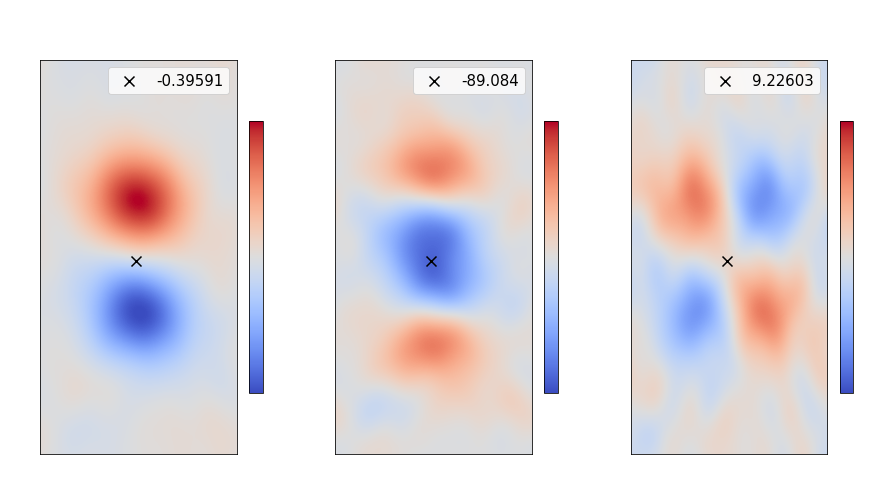

In [14]:
from utils.BasinPlot import *

fig, axs = imshow3([true_eta, true_hu, true_hv])
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)

### Single-level Ensemble

In [15]:
from utils.BasinSL import *

In [16]:
SL_Ne = 50

In [17]:
SL_ensemble = initSLensemble(SL_Ne, args, data_args, sample_args, 
                    init_model_error_basis_args=init_model_error_basis_args, 
                    sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=sim_model_error_timestep)


(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

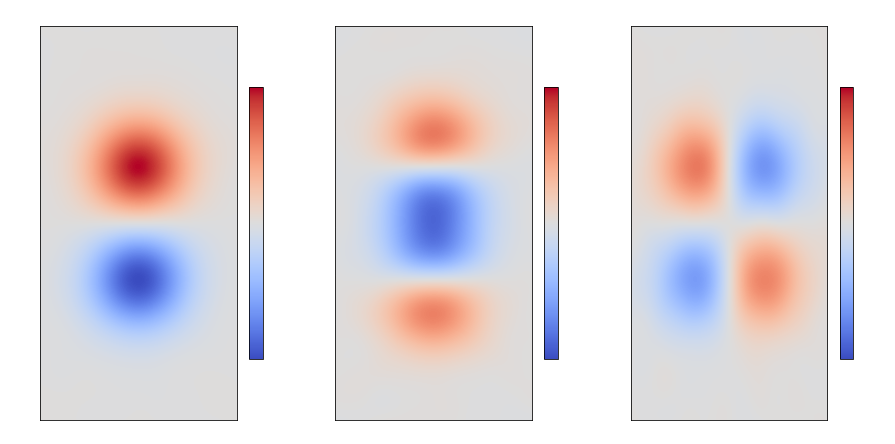

In [18]:
imshow3(SLestimate(SL_ensemble, np.mean))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

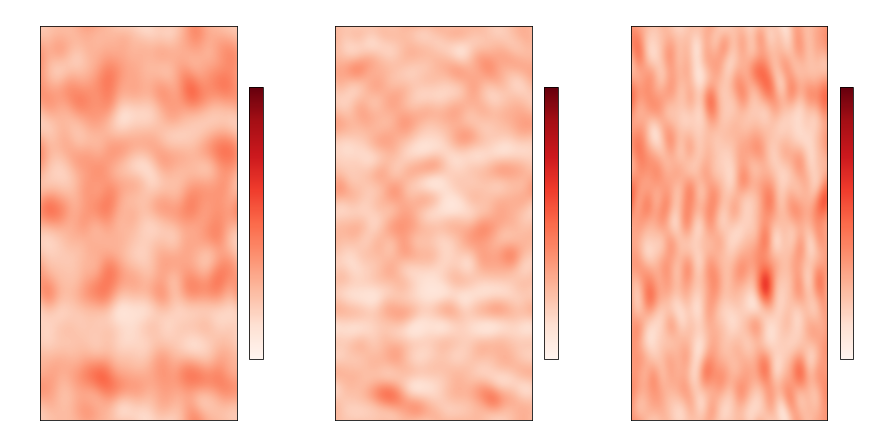

In [19]:
imshow3var(SLestimate(SL_ensemble, np.var))

### Kalman gain

In [20]:
GC = GCweights(SL_ensemble, obs_x, obs_y, r)

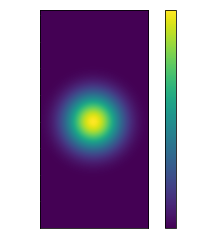

In [21]:
plt.imshow(GC, origin="lower")
plt.colorbar()

In [22]:
# obs_var = slice(0,1) # eta
obs_var = slice(1,3) # hu and hv
# obs_var = slice(0,3) # eta, hu, hv

In [23]:
if obs_var.step is None:
    obs_varN = (obs_var.stop - obs_var.start) 
else: 
    obs_varN = (obs_var.stop - obs_var.start)/obs_var.step

In [24]:
SL_state = SLdownload(SL_ensemble)

In [25]:
SL_prior = copy.deepcopy(SL_state)

In [26]:
obs_idxs = [Hy, Hx]

In [27]:
X0 = SL_state
X0mean = np.average(X0, axis=-1)

Y0 = SL_state[obs_var,obs_idxs[0],obs_idxs[1]]
Y0mean = np.average(Y0, axis=-1)


In [28]:
SL_XY = (1/SL_Ne*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (obs_varN,))

In [29]:
SL_HXY = SL_XY[obs_var,obs_idxs[0],obs_idxs[1],:]
SL_YY  = SL_HXY + np.diag(R[obs_var])

SL_K = SL_XY @ np.linalg.inv(SL_YY)

Text(0.5, 0.9, 'Kalman Gain')

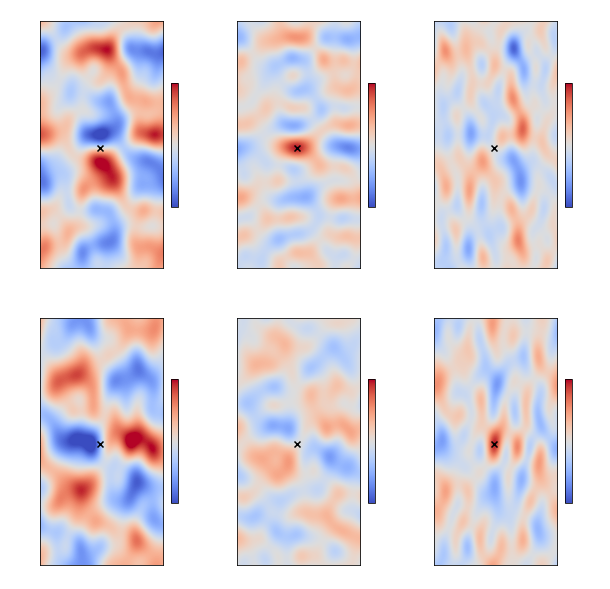

In [30]:
vlims = [[1, 0.01, 0.01],[10, 1, 1],[10, 1, 1]]

fig, axs = plt.subplots(obs_varN,3, figsize=(10,5*obs_varN))
for i in range(obs_var.start, obs_var.stop):
    for j in range(3):
        
        if obs_varN == 1:
            ax = axs[j]
        elif obs_varN > 1:
            ax = axs[i-obs_var.start,j]
            
        im = ax.imshow(SL_K[j,:,:,i-obs_var.start], vmin=-vlims[j][i],vmax=vlims[j][i], cmap="coolwarm")
        ax.scatter(Hx, Hy, marker="x", c="black")
        plt.colorbar(im, ax=ax, shrink=0.5)

fig.suptitle("Kalman Gain", y=0.9)

### Update

In [31]:
SL_perts = np.random.multivariate_normal(np.zeros(3)[obs_var], np.diag(R[obs_var]), size=SL_Ne)

In [32]:
SL_state = SL_state + (SL_K @ (obs[obs_var,np.newaxis] - SL_state[obs_var,obs_idxs[0],obs_idxs[1]] - SL_perts.T))


(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

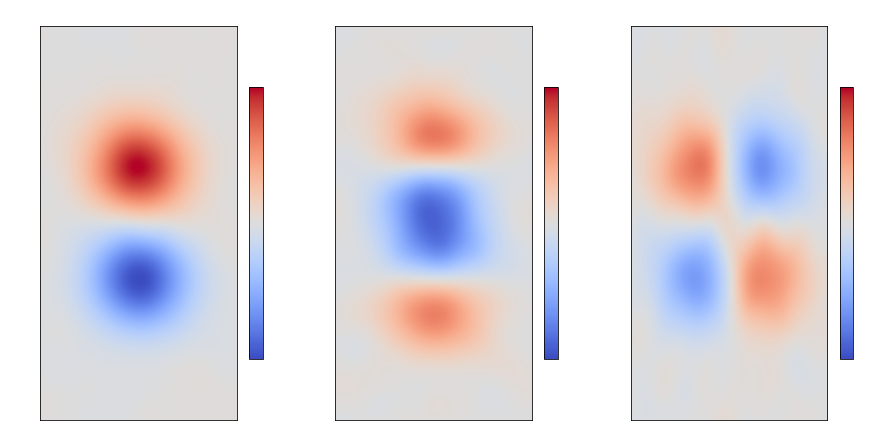

In [33]:
imshow3(np.average(SL_state, axis=-1))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

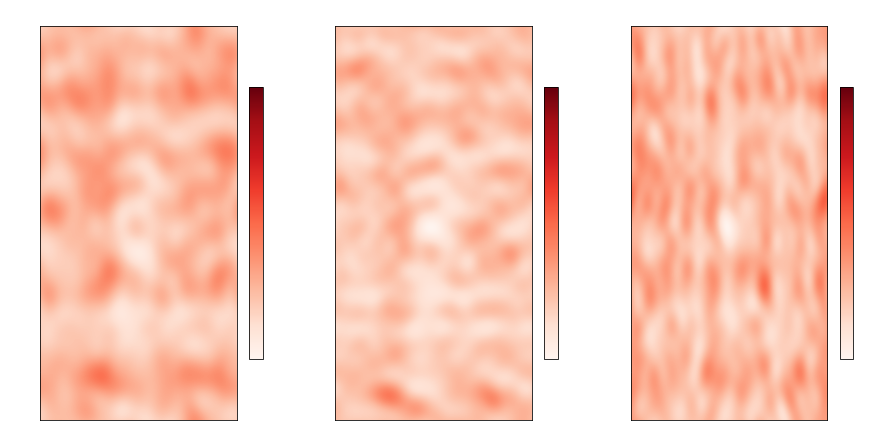

In [34]:
imshow3var(np.var(SL_state, axis=-1))

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

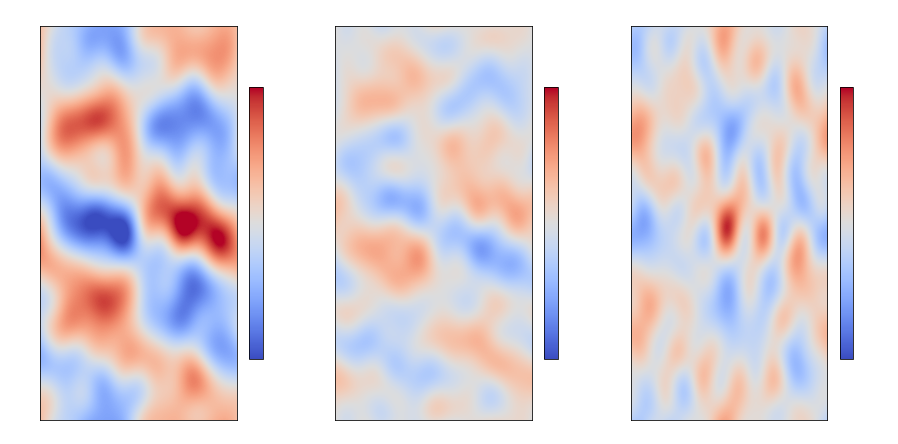

In [35]:
imshow3(np.mean(SL_state - SL_prior, axis=-1), eta_vlim=0.1, huv_vlim=10)